# Glomerulus - MLP model

In [ ]:
%%shell

# Dataset (from drive: should be faster than uploading manually?)
# see https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
if [ ! -d "Glomerulus" ] ; then
    cp /path/to/zipped/dataset Glomerulus.zip
    # force overwrite with -o (has to go before zipfile name)
    unzip -o Glomerulus.zip
fi

Archive:  Glomerulus.zip
   creating: Glomerulus/
   creating: Glomerulus/Normal/
   creating: Glomerulus/Normal/teste/
   creating: Glomerulus/Normal/teste/PICRO/
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (9).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (22).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (46).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (37).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (34).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (25).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (3).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (27).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (31).JPG  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (26).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (30).JPG  
  inflating: Glomerulus/Normal/teste/PICRO/teste_picro (39).jpg  
  inflating: Glomerulus/Normal/teste/PICRO/tes

In [ ]:
%%shell

if [ ! -d "train_data" ] ; then
    cp -r /path/to/train_data_folder train_data
fi
if [ ! -d "test_data" ] ; then
    cp -r /path/to/test_data_folder test_data
fi

# Glomerulus - Classification Models (binary)

In [ ]:
# from tqdm.notebook import trange, tqdm
# !jupyter nbextension enable --py widgetsnbextension
## for making tqdm progress bars work in notebook
## see https://stackoverflow.com/questions/67998191/importerror-iprogress-not-found-please-update-jupyter-and-ipywidgets-although

from tqdm import tqdm
import os, sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.datasets
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

 ## Dataset and dataloader

In [ ]:
class_names = ("Normal", "Crescente")
name_dataset = "Glomerulus"
name_features = ["LBP", "contrast", "sobel"]
train_folder = "train_data"
test_folder = "test_data"

 In this section we break down the `.npy` large files into separate files per image.


 Let $N$ be the number of images in the dataset (2759). The `.npy` file structure is the following:

 1.  The GLCM feature is a tensor of $N \times 256 \times 256 \times 5$ entries, flattened to a matrix $N \times (256 \cdot 256 \cdot 5)$
 2.  The Sobel features is a tensor of $N \times 768 \times 1024$, flattened to a matrix of $N \times (768 \cdot 1024)$
 3.  The contrast features is a tensor of $N \times 5$ (one value for each of the 5 GLCM offsets). However, probably only the first filter is relevant (i.e the first column)
 4.  The LBP features is a tensor of $N \times 768 \times 1024$, flattened to a matrix of $N \times (768 \cdot 1024)$

 Now, we create a dataset that will be able to load all these `.npz`/`.npy` files and use them.

In [ ]:
def loader(filepath: str):
    a = np.load(filepath)
    torch_tensor = torch.from_numpy(a["flat"])
    return torch_tensor.to(torch.float32) ## NOTE model params use float32 by default

## TODO differentiate train and test folders

train_dataset = torchvision.datasets.DatasetFolder(
    train_folder, loader = loader,
    extensions=("npy", "npz"),
    target_transform=lambda x : torch.tensor(x, dtype=torch.float32))

test_dataset = torchvision.datasets.DatasetFolder(
    test_folder, loader = loader,
    extensions=("npy", "npz"),
    target_transform=lambda x : torch.tensor(x, dtype=torch.float32))

print(f"Working with total of {len(train_dataset)} training images")
print(f"Working with total of {len(test_dataset)} test images")

## test the dataloader
# dummy_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=True)
# feat, label = next(iter(dummy_loader))

# print(f"Feature={feat}", f"of shape={feat.shape} and label {label}", sep="\n")


Working with total of 9645 training images
Working with total of 9549 test images


 # MLP

 ## Parameters

In [ ]:
## IMG size
IMG_SIZE = (192, 256)
NUM_FILTERS_CONTRAST = 5

## loading
batch_size = 64
num_workers = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")
shuffle=True

## model
feat_dim = 2 * IMG_SIZE[0] * IMG_SIZE[1] + NUM_FILTERS_CONTRAST
layers = [32, 512, 1024, 128]
dropouts = [0.4, 0.1, 0.3, 0.3, 0.1]
leak = 0.02

epochs = 100

lr = 3e-4
weight_decay = 1e-4 ## L2 penalty
sgd_momentum = 1e-3
optimizer_name = "sgd"
criterion = torch.nn.BCELoss(reduction='mean') ## batch sum

## roc
roc_resolution = 1000
pr_resolution = 1000

model_name = "model1"

## saving
model_folder = f"{model_name}"
log_path = f"{model_name}/log_mlp_" + model_name + "_" + str(datetime.now()) + ".txt"
plot_path = [
    f"{model_name}/plot_train_mlp_" + model_name + "_" + str(datetime.now()) + ".pdf",
    f"{model_name}/plot_test_mlp_" + model_name + "_" + str(datetime.now()) + ".pdf",
    f"{model_name}/plot_both_mlp_" + model_name + "_" + str(datetime.now()) + ".pdf"
]

roc_path = f"{model_name}/roc_mlp_" + model_name + "_" + str(datetime.now()) + ".pdf"
pr_path = f"{model_name}/pr_path_" + model_name + "_" + str(datetime.now()) + ".pdf"

checkpoint_path = f"{model_name}/checkpoint" + model_name + "_" + str(datetime.now()) + ".pth.tar"
## TODO : early stopping?


Running on cuda


## Meters

In [ ]:
class Meter:
    def __init__(self):
        self.TP : int = 0
        self.TN : int = 0
        self.FP : int = 0
        self.FN : int = 0
        self.total : int = 0
        self.history : dict[str, list[float]] = {
            "acc": [],
            "precision": [],
            "recall": [],
            "specificity": [],
            "f1_score": []
        }

    def reset(self, del_history = False):
        self.TP = 0
        self.TN = 0
        self.FP = 0
        self.FN = 0
        self.total = 0
        if del_history:
            self.history = {
                "acc": [],
                "precision": [],
                "recall": [],
                "specificity": [],
                "f1_score": []
            }

    def update(self,
               out: torch.Tensor,
               labels: torch.Tensor,
               threshold: float = 0.5):
        """
        We consider by default that probabilities exactly 0.5 correspond to label 0
        """
        ## TODO is this float comparison 100% safe?
        with torch.no_grad():
            hard_out = out > threshold
            self.TP += torch.sum((hard_out == 1.0) * (labels == 1.0)).item()
            self.TN += torch.sum((hard_out == 0.0) * (labels == 0.0)).item()
            self.FP += torch.sum((hard_out == 1.0) * (labels == 0.0)).item()
            self.FN += torch.sum((hard_out == 0.0) * (labels == 1.0)).item()
        self.total += len(labels)

    def save_epoch(self, reset=True):
        self.history["acc"].append(self.acc())
        self.history["precision"].append(self.precision())
        self.history["recall"].append(self.recall())
        self.history["specificity"].append(self.specificity())
        self.history["f1_score"].append(self.f1_score())
        if reset:
            self.reset(del_history=False)

    def acc(self):
        return (self.TP + self.TN) / self.total

    def precision(self):
        """
        Positive predictive value (PPV)
        -- proportion of true positives to output positives
        """
        try:
            return (self.TP) / (self.TP + self.FP)
        except ZeroDivisionError:
            return float('inf')

    def recall(self):
        """
        True positive rate (TPV)
        -- how many of actual positives were identified
        """
        try:
            return (self.TP) / (self.TP + self.FN)
        except ZeroDivisionError:
            return float('inf')

    def specificity(self):
        """
        True negative rate (TNV)
        -- how many negatives were identified
        """
        try:
            return (self.TN) / (self.TN + self.FP)
        except ZeroDivisionError:
            return float('inf')

    def f1_score(self):
        """
        Harmonic mean of precision and sensitivity/recall:
        F1 = 2 / (1/precision + 1/recall)
        F1 = (2 * precision * recall) / (precision + recall)
        """
        try:
            P = self.precision()
            R = self.recall()
            return (2 * P * R) / (P + R)
        except ZeroDivisionError:
            return float('inf')

## Writers

In [ ]:
class Writer:
    def __init__(self, log_path: str, *, overwrite : bool = False):
        if overwrite:
            self.file = open(log_path, "w") ## w, not a (append)
            ## -> overwrites existing content
        else:
            self.file = open(log_path, "a")

    ##'loss/train (average per element)', avg_loss, i
    def add_scalar(
        self,
        label: str,
        metric: float,
        epoch: int
    ):
        self.file.write(f"Epoch {epoch}: {label}: {metric}\n")

    def print_info(
        self,
        meter: Meter,
        epoch: int,
        mode: str = "train",
        *,
        verbose : bool = True,
        inference: bool = False
    ):
        self.file.write(80 * "-" + "\n")
        if not inference:
            if verbose:
                print(f"Epoch {epoch}")
            self.file.write(f"Epoch {epoch}\n")
        if verbose:
            print(80 * "-")
            print(f"acc/{mode}: {meter.acc()}")
            print(f"precision/{mode}: {meter.precision()}")
            print(f"recall/{mode}: {meter.recall()}")
            print(f"spec/{mode}: {meter.specificity()}")
            print(f"f1/{mode}: {meter.f1_score()}")
            print(80 * "-")
        self.add_scalar(f"acc/{mode}", meter.acc(), epoch)
        self.add_scalar(f"precision/{mode}", meter.precision(), epoch)
        self.add_scalar(f"recall/{mode}", meter.recall(), epoch)
        self.add_scalar(f"specificity/{mode}", meter.specificity(), epoch)
        self.add_scalar(f"f1/{mode}", meter.f1_score(), epoch)
        self.file.write(80 * "-" + "\n")

    def end_writer(self):
        self.file.close()

 ## Training

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 feat_dim: int,
                 layers: list,
                 dropouts: list,
                 leak: float = 0.02,
                 use_batch_norm: bool = True):
        super().__init__()

        self.dropouts = dropouts
        self.ext_layers = [feat_dim] + layers
        ## for each hidden layer i there is a dropout in the connection
        ## (i - 1) -> i, and there is a final dropout from the final hidden
        ## to the output layer
        assert len(layers) + 1 == len(dropouts)

        ## TODO add customizable batch normalization or instance normalization
        self.model = nn.ModuleList()
        self.model.append(nn.BatchNorm1d(feat_dim))
        for i in range(len(self.ext_layers) - 1):
            self.model.append(nn.Linear(self.ext_layers[i], self.ext_layers[i + 1]))
            self.model.append(nn.Dropout(self.dropouts[i]))
            self.model.append(nn.LeakyReLU(negative_slope=leak, inplace=True))
            if use_batch_norm:
                self.model.append(nn.BatchNorm1d(self.ext_layers[i + 1]))
        self.model.append(nn.Linear(self.ext_layers[-1], 1))
        self.model.append(nn.Dropout(self.dropouts[-1]))
        self.model.append(nn.Sigmoid())

    def forward(self, feat: torch.Tensor) -> torch.Tensor:
        for layer in self.model:
            feat = layer(feat)
        return feat.flatten()

In [ ]:
def train_loop(model: MLP,
               trainloader: torch.utils.data.DataLoader,
               val_loader: torch.utils.data.DataLoader,
               epochs: int,
               criterion,
               optim,
               device : str,
               checkpoint_path: str,
               log_path: str,
               *,
               validation = True,
               scheduler: torch.optim.lr_scheduler = None):

    ## create model folder
    model_folder = "/".join(checkpoint_path.split("/")[:-1])
    if (not os.path.isdir(model_folder)):
        os.mkdir(model_folder)

    writer = Writer(log_path, overwrite=True)
    test_writer = Writer(log_path, overwrite=False)
    min_loss : float = float('inf')
    best_epoch = 0
    meter = Meter()
    test_meter = Meter()

    model = model.to(device)
    writer.file.write("\n".join([80 * "-", str(model), 80 * "-"]))
    print("\n".join([80 * "-", str(model), 80 * "-"]))


    for i in range(1, epochs + 1):
        model.train() ## training mode
        running_loss = 0.0
        batch_cnt = 0

        for j, (feat, label) in tqdm(enumerate(trainloader), total=len(trainloader)):
            optim.zero_grad()
            model.zero_grad()
            feat = feat.to(device)
            label = label.to(device)
            out = model(feat)

            loss = criterion(out, label)
            running_loss += loss.item()

            loss.backward()
            optim.step()
            batch_cnt += 1
            meter.update(out, label)

        avg_loss = running_loss / batch_cnt
        writer.add_scalar('loss/train (average per element)', avg_loss, i)
        if avg_loss < min_loss:
            print(f"Loss reduced from {min_loss} to {avg_loss} ({i}/{epochs})")
            min_loss = avg_loss
            best_epoch = i
            print(f"Saving checkpoint to {checkpoint_path}")
            torch.save(model.state_dict(), checkpoint_path)

        writer.print_info(meter, i, mode="train")
        meter.save_epoch()

        ## validation
        if validation:
            model.eval() ## validation mode
            with torch.no_grad():
                for feat, label in tqdm(testloader, total=len(testloader)):
                    feat = feat.to(device)
                    label = label.to(device)
                    out = model(feat)
                    test_meter.update(out, label)
            test_writer.print_info(test_meter, i, mode="test")
            if scheduler is not None:
                scheduler.step(test_meter.f1_score())
            test_meter.save_epoch() ## has to come last!

    if log_path is not None:
        writer.end_writer()
        test_writer.end_writer()

    return meter, test_meter

 ### Initializating training process

In [ ]:
model = MLP(feat_dim, layers, dropouts, leak, use_batch_norm=True)
trainloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=num_workers)
testloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=shuffle,
                        num_workers=num_workers)

if (optimizer_name == 'adam'):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif (optimizer_name == 'sgd'):
    optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=sgd_momentum)
else: ## default: adam
    optim = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'max', min_lr = lr / 3)

print(model)

MLP(
  (model): ModuleList(
    (0): BatchNorm1d(98309, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=98309, out_features=32, bias=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): LeakyReLU(negative_slope=0.02, inplace=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=32, out_features=512, bias=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): LeakyReLU(negative_slope=0.02, inplace=True)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): LeakyReLU(negative_slope=0.02, inplace=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=1024, out_features=128, bias=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): LeakyReLU(negative_slope=0.

In [ ]:
meter, test_meter = train_loop(model,
                               trainloader,
                               testloader,
                               epochs,
                               criterion,
                               optim,
                               device,
                               checkpoint_path,
                               log_path,
                               scheduler=scheduler)

print(f" Best epoch (according to F1 score): {np.argmax(meter.history['f1_score']) + 1} ".center(80, '-'))

--------------------------------------------------------------------------------
MLP(
  (model): ModuleList(
    (0): BatchNorm1d(98309, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=98309, out_features=32, bias=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): LeakyReLU(negative_slope=0.02, inplace=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=32, out_features=512, bias=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): LeakyReLU(negative_slope=0.02, inplace=True)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): LeakyReLU(negative_slope=0.02, inplace=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=1024, out_features=128, bias=Tr

100%|██████████| 151/151 [00:50<00:00,  3.00it/s]


Loss reduced from inf to 0.7135883407876981 (1/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 1
--------------------------------------------------------------------------------
acc/train: 0.5153965785381026
precision/train: 0.6105960264900663
recall/train: 0.41840624432746415
spec/train: 0.6445841392649904
f1/train: 0.49655320982335205
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:46<00:00,  3.24it/s]


Epoch 1
--------------------------------------------------------------------------------
acc/test: 0.5461304848675254
precision/test: 0.6726417866588305
recall/test: 0.4155019059720457
spec/test: 0.7242574257425742
f1/test: 0.5136894075403948
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]


Loss reduced from 0.7135883407876981 to 0.6665082214683886 (2/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 2
--------------------------------------------------------------------------------
acc/train: 0.5796785899429756
precision/train: 0.6854448126433852
recall/train: 0.4881103648575059
spec/train: 0.7016441005802708
f1/train: 0.5701865988125531
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 2
--------------------------------------------------------------------------------
acc/test: 0.609487904492617
precision/test: 0.796469020652898
recall/test: 0.4340170629878381
spec/test: 0.8487623762376237
f1/test: 0.5618611209023617
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.31it/s]


Loss reduced from 0.6665082214683886 to 0.6101794590223704 (3/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 3
--------------------------------------------------------------------------------
acc/train: 0.6496630378434421
precision/train: 0.764662027833002
recall/train: 0.5585405699764022
spec/train: 0.7710348162475822
f1/train: 0.6455470470995489
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 3
--------------------------------------------------------------------------------
acc/test: 0.6662477746360875
precision/test: 0.7960224375318715
recall/test: 0.5667090216010165
spec/test: 0.801980198019802
f1/test: 0.6620718905736402
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Loss reduced from 0.6101794590223704 to 0.5535368125959738 (4/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 4
--------------------------------------------------------------------------------
acc/train: 0.7053395541731468
precision/train: 0.8265980896399706
recall/train: 0.6126338718460701
spec/train: 0.8288201160541586
f1/train: 0.7037114261884905
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


Epoch 4
--------------------------------------------------------------------------------
acc/test: 0.6846790239815688
precision/test: 0.8033025740650801
recall/test: 0.6004719549827555
spec/test: 0.7995049504950495
f1/test: 0.6872338215435754
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.44it/s]


Loss reduced from 0.5535368125959738 to 0.4968211254141978 (5/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 5
--------------------------------------------------------------------------------
acc/train: 0.7646448937273198
precision/train: 0.8853200095170116
recall/train: 0.6754401887819931
spec/train: 0.8834622823984526
f1/train: 0.7662685337726524
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 5
--------------------------------------------------------------------------------
acc/test: 0.7106503298774741
precision/test: 0.8162137263933671
recall/test: 0.643310945725177
spec/test: 0.8024752475247525
f1/test: 0.7195208608263122
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Loss reduced from 0.4968211254141978 to 0.4413230993495082 (6/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 6
--------------------------------------------------------------------------------
acc/train: 0.8054950751684811
precision/train: 0.9138755980861244
recall/train: 0.7280813214739518
spec/train: 0.9086073500967118
f1/train: 0.8104667609618105
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.61it/s]


Epoch 6
--------------------------------------------------------------------------------
acc/test: 0.7249973819248089
precision/test: 0.7860686644175432
recall/test: 0.7190052641132691
spec/test: 0.7331683168316832
f1/test: 0.7510428517254455
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.34it/s]


Loss reduced from 0.4413230993495082 to 0.3932988027863155 (7/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 7
--------------------------------------------------------------------------------
acc/train: 0.8393986521513738
precision/train: 0.9398045313194135
recall/train: 0.7680159738609548
spec/train: 0.934477756286267
f1/train: 0.8452702027769453
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


Epoch 7
--------------------------------------------------------------------------------
acc/test: 0.7304429783223374
precision/test: 0.8064314053038213
recall/test: 0.7010346705391178
spec/test: 0.7705445544554456
f1/test: 0.7500485531171103
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Loss reduced from 0.3932988027863155 to 0.35880174601314874 (8/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 8
--------------------------------------------------------------------------------
acc/train: 0.8530844997407984
precision/train: 0.9447826086956522
recall/train: 0.7888909057905246
spec/train: 0.938588007736944
f1/train: 0.8598278761499654
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:36<00:00,  4.15it/s]


Epoch 8
--------------------------------------------------------------------------------
acc/test: 0.7279296261388627
precision/test: 0.8007852862161604
recall/test: 0.7033944454528953
spec/test: 0.7613861386138614
f1/test: 0.7489369926555857
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Loss reduced from 0.35880174601314874 to 0.3242581965315421 (9/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 9
--------------------------------------------------------------------------------
acc/train: 0.8752721617418352
precision/train: 0.9658156642146257
recall/train: 0.8103104011617354
spec/train: 0.9617988394584139
f1/train: 0.8812555522653244
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 9
--------------------------------------------------------------------------------
acc/test: 0.7322232694522987
precision/test: 0.7985436893203883
recall/test: 0.7166454891994918
spec/test: 0.7534653465346535
f1/test: 0.7553812302688223
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Loss reduced from 0.3242581965315421 to 0.29098623379176813 (10/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 10
--------------------------------------------------------------------------------
acc/train: 0.8910316226023847
precision/train: 0.9750639386189258
recall/train: 0.8304592485024506
spec/train: 0.9717117988394585
f1/train: 0.8969708852073326
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.63it/s]


Epoch 10
--------------------------------------------------------------------------------
acc/test: 0.7292910252382448
precision/test: 0.774915381722452
recall/test: 0.7480486476674533
spec/test: 0.7037128712871287
f1/test: 0.76124503555925
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Loss reduced from 0.29098623379176813 to 0.2671985046950397 (11/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 11
--------------------------------------------------------------------------------
acc/train: 0.9000518403317781
precision/train: 0.9769150052465897
recall/train: 0.8449809402795425
spec/train: 0.973404255319149
f1/train: 0.906170916877555
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Epoch 11
--------------------------------------------------------------------------------
acc/test: 0.7345271756204839
precision/test: 0.7896377093883912
recall/test: 0.7358867308041387
spec/test: 0.7326732673267327
f1/test: 0.76181527764728
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.44it/s]


Loss reduced from 0.2671985046950397 to 0.2492090210022516 (12/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 12
--------------------------------------------------------------------------------
acc/train: 0.9051321928460342
precision/train: 0.982563025210084
recall/train: 0.8489744055182429
spec/train: 0.9799323017408124
f1/train: 0.9108968740870581
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 12
--------------------------------------------------------------------------------
acc/test: 0.7270918420777045
precision/test: 0.7643416499726826
recall/test: 0.7618442548556907
spec/test: 0.6797029702970298
f1/test: 0.7630909090909092
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.2492090210022516 to 0.2316927947350685 (13/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 13
--------------------------------------------------------------------------------
acc/train: 0.9170554691550026
precision/train: 0.9845647252521095
recall/train: 0.8683971682701035
spec/train: 0.9818665377176016
f1/train: 0.9228395061728395
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


Epoch 13
--------------------------------------------------------------------------------
acc/test: 0.7280343491465074
precision/test: 0.7684365781710915
recall/test: 0.7565801415864948
spec/test: 0.689108910891089
f1/test: 0.7624622701911642
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Loss reduced from 0.2316927947350685 to 0.21657160871865733 (14/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 14
--------------------------------------------------------------------------------
acc/train: 0.9174701918092276
precision/train: 0.9877872076174705
recall/train: 0.8662189145035397
spec/train: 0.9857350096711799
f1/train: 0.9230174081237911
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Epoch 14
--------------------------------------------------------------------------------
acc/test: 0.727301288092994
precision/test: 0.761100125831386
recall/test: 0.7685605373025958
spec/test: 0.6710396039603961
f1/test: 0.7648121387283238
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Loss reduced from 0.21657160871865733 to 0.20665448163913575 (15/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 15
--------------------------------------------------------------------------------
acc/train: 0.9203732503888025
precision/train: 0.9908883826879271
recall/train: 0.8685786894173171
spec/train: 0.9893617021276596
f1/train: 0.9257109692396981
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


Epoch 15
--------------------------------------------------------------------------------
acc/test: 0.7299193632841136
precision/test: 0.7746531683539557
recall/test: 0.7500453802868035
spec/test: 0.7024752475247524
f1/test: 0.7621506963017615
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.51it/s]


Loss reduced from 0.20665448163913575 to 0.1991334631052238 (16/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 16
--------------------------------------------------------------------------------
acc/train: 0.9182996371176776
precision/train: 0.9904425514232288
recall/train: 0.8653113087674714
spec/train: 0.9888781431334622
f1/train: 0.9236582057740749
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 16
--------------------------------------------------------------------------------
acc/test: 0.7355744056969317
precision/test: 0.7573301138323559
recall/test: 0.7970593574151389
spec/test: 0.6517326732673268
f1/test: 0.7766870080481117
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Loss reduced from 0.1991334631052238 to 0.1902756356936417 (17/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 17
--------------------------------------------------------------------------------
acc/train: 0.9248315189217211
precision/train: 0.991170431211499
recall/train: 0.8762025776002904
spec/train: 0.9896034816247582
f1/train: 0.9301474130455728
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.65it/s]


Epoch 17
--------------------------------------------------------------------------------
acc/test: 0.7287674102000209
precision/test: 0.7778412335808109
recall/test: 0.7416954075149755
spec/test: 0.7111386138613861
f1/test: 0.7593384129343989
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Loss reduced from 0.1902756356936417 to 0.1769315701052053 (18/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 18
--------------------------------------------------------------------------------
acc/train: 0.9212026956972524
precision/train: 0.9915131442765474
recall/train: 0.8694862951533854
spec/train: 0.9900870406189555
f1/train: 0.9264990328820116
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


Epoch 18
--------------------------------------------------------------------------------
acc/test: 0.7359932977275108
precision/test: 0.7714389534883721
recall/test: 0.7707387910691595
spec/test: 0.6886138613861386
f1/test: 0.7710887133387814
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Loss reduced from 0.1769315701052053 to 0.1701817579123358 (19/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 19
--------------------------------------------------------------------------------
acc/train: 0.928564022809746
precision/train: 0.9912352221769262
recall/train: 0.8827373388999818
spec/train: 0.9896034816247582
f1/train: 0.9338454152664426
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.53it/s]


Epoch 19
--------------------------------------------------------------------------------
acc/test: 0.7331657765211017
precision/test: 0.7735082209495658
recall/test: 0.7600290433835541
spec/test: 0.6965346534653465
f1/test: 0.766709393883904
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Loss reduced from 0.1701817579123358 to 0.16290015372022099 (20/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 20
--------------------------------------------------------------------------------
acc/train: 0.9284603421461898
precision/train: 0.995068830901993
recall/train: 0.8791069159557089
spec/train: 0.9941972920696325
f1/train: 0.9335003855050116
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 20
--------------------------------------------------------------------------------
acc/test: 0.7283485181694418
precision/test: 0.744916820702403
recall/test: 0.8046832455981122
spec/test: 0.6242574257425743
f1/test: 0.7736474694589878
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.34it/s]


Loss reduced from 0.16290015372022099 to 0.15849264197989016 (21/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 21
--------------------------------------------------------------------------------
acc/train: 0.9316744427164334
precision/train: 0.9953022875816994
recall/train: 0.8845525503721183
spec/train: 0.9944390715667312
f1/train: 0.9366650648726573
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.39it/s]


Epoch 21
--------------------------------------------------------------------------------
acc/test: 0.7311760393758509
precision/test: 0.7572577824414131
recall/test: 0.7859865674351062
spec/test: 0.6564356435643565
f1/test: 0.7713547697514919
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Loss reduced from 0.15849264197989016 to 0.1549641483568198 (22/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 22
--------------------------------------------------------------------------------
acc/train: 0.9324002073613271
precision/train: 0.9934972566551514
recall/train: 0.8874568887275368
spec/train: 0.9922630560928434
f1/train: 0.9374880153403644
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 22
--------------------------------------------------------------------------------
acc/test: 0.7316996544140748
precision/test: 0.7531352001374334
recall/test: 0.7957887093846433
spec/test: 0.6443069306930693
f1/test: 0.7738746690203001
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Loss reduced from 0.1549641483568198 to 0.15456696130976771 (23/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 23
--------------------------------------------------------------------------------
acc/train: 0.9298081907724209
precision/train: 0.9958949096880131
recall/train: 0.8807406062806317
spec/train: 0.995164410058027
f1/train: 0.9347847028224641
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.62it/s]


Epoch 23
--------------------------------------------------------------------------------
acc/test: 0.7304429783223374
precision/test: 0.7575917149376865
recall/test: 0.7834452713741151
spec/test: 0.6581683168316832
f1/test: 0.7703016241299303
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.40it/s]


Loss reduced from 0.15456696130976771 to 0.14389123254461794 (24/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 24
--------------------------------------------------------------------------------
acc/train: 0.936547433903577
precision/train: 0.9949464321811199
recall/train: 0.8934470865855872
spec/train: 0.9939555125725339
f1/train: 0.941469013006886
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 24
--------------------------------------------------------------------------------
acc/test: 0.7253115509477432
precision/test: 0.7369458128078817
recall/test: 0.8146669086948629
spec/test: 0.6034653465346534
f1/test: 0.7738598155013363
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Loss reduced from 0.14389123254461794 to 0.13598635925954541 (25/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 25
--------------------------------------------------------------------------------
acc/train: 0.9399688958009331
precision/train: 0.9965753424657534
recall/train: 0.8979851152659285
spec/train: 0.995889748549323
f1/train: 0.9447149813806932
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Epoch 25
--------------------------------------------------------------------------------
acc/test: 0.725939888993612
precision/test: 0.7431069266980498
recall/test: 0.8023234706843347
spec/test: 0.6217821782178218
f1/test: 0.7715806930260977
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.34it/s]


Loss reduced from 0.13598635925954541 to 0.13571164875433145 (26/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 26
--------------------------------------------------------------------------------
acc/train: 0.9303265940902021
precision/train: 0.9946819390468399
recall/train: 0.8827373388999818
spec/train: 0.9937137330754352
f1/train: 0.9353721869590307
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Epoch 26
--------------------------------------------------------------------------------
acc/test: 0.7276154571159283
precision/test: 0.7621709340064912
recall/test: 0.7672898892721002
spec/test: 0.6735148514851486
f1/test: 0.7647218453188602
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.37it/s]


Loss reduced from 0.13571164875433145 to 0.1296818619532301 (27/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 27
--------------------------------------------------------------------------------
acc/train: 0.9371695178849144
precision/train: 0.9961546245699251
recall/train: 0.8934470865855872
spec/train: 0.9954061895551257
f1/train: 0.9420095693779904
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 27
--------------------------------------------------------------------------------
acc/test: 0.7289768562153105
precision/test: 0.7442716173273123
recall/test: 0.8077691051007443
spec/test: 0.6215346534653465
f1/test: 0.7747214484679665
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.40it/s]


Loss reduced from 0.1296818619532301 to 0.12741035358696584 (28/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 28
--------------------------------------------------------------------------------
acc/train: 0.9367547952306895
precision/train: 0.9941496873108735
recall/train: 0.8945362134688691
spec/train: 0.9929883945841392
f1/train: 0.9417160328683357
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.54it/s]


Epoch 28
--------------------------------------------------------------------------------
acc/test: 0.7271965650853492
precision/test: 0.7516464471403813
recall/test: 0.7872572154656018
spec/test: 0.6452970297029703
f1/test: 0.7690398084936608
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 29
--------------------------------------------------------------------------------
acc/train: 0.9337480559875583
precision/train: 0.9965334420880914
recall/train: 0.8870938464331095
spec/train: 0.995889748549323
f1/train: 0.9386343993085566
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 29
--------------------------------------------------------------------------------
acc/test: 0.7261493350089014
precision/test: 0.7383855024711697
recall/test: 0.813577781811581
spec/test: 0.6069306930693069
f1/test: 0.7741601174540115
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Epoch 30
--------------------------------------------------------------------------------
acc/train: 0.9356143079315707
precision/train: 0.9965461194636327
recall/train: 0.8903612270829552
spec/train: 0.995889748549323
f1/train: 0.9404659188955997
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 30
--------------------------------------------------------------------------------
acc/test: 0.7246832129018745
precision/test: 0.7360655737704918
recall/test: 0.8150299509892902
spec/test: 0.6014851485148515
f1/test: 0.7735377724179516
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.29it/s]


Epoch 31
--------------------------------------------------------------------------------
acc/train: 0.9351995852773458
precision/train: 0.9989783408255006
recall/train: 0.8874568887275368
spec/train: 0.9987911025145068
f1/train: 0.9399211765836778
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.32it/s]


Epoch 31
--------------------------------------------------------------------------------
acc/test: 0.7242643208712954
precision/test: 0.7663949610967025
recall/test: 0.7509529860228716
spec/test: 0.6878712871287128
f1/test: 0.7585953974511782
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.28it/s]


Epoch 32
--------------------------------------------------------------------------------
acc/train: 0.9385173665111457
precision/train: 0.9959644874899112
recall/train: 0.8959883826465783
spec/train: 0.995164410058027
f1/train: 0.9433349259436216
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 32
--------------------------------------------------------------------------------
acc/test: 0.7227981987642685
precision/test: 0.7473211199446941
recall/test: 0.7848974405518243
spec/test: 0.6381188118811881
f1/test: 0.7656485170429393
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Loss reduced from 0.12741035358696584 to 0.12318513974152653 (33/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 33
--------------------------------------------------------------------------------
acc/train: 0.9376879212026957
precision/train: 0.9961585119288314
recall/train: 0.8943546923216554
spec/train: 0.9954061895551257
f1/train: 0.9425155428024868
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 33
--------------------------------------------------------------------------------
acc/test: 0.7252068279400984
precision/test: 0.7375267577803392
recall/test: 0.8130332183699401
spec/test: 0.6054455445544554
f1/test: 0.773441547228458
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 34
--------------------------------------------------------------------------------
acc/train: 0.9401762571280456
precision/train: 0.9965767217076118
recall/train: 0.8983481575603558
spec/train: 0.995889748549323
f1/train: 0.9449164677804296
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.59it/s]


Epoch 34
--------------------------------------------------------------------------------
acc/test: 0.7291863022306001
precision/test: 0.7743570489956824
recall/test: 0.7487747322563079
spec/test: 0.7024752475247524
f1/test: 0.7613510520487264
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Epoch 35
--------------------------------------------------------------------------------
acc/train: 0.9394504924831519
precision/train: 0.9971734302442964
recall/train: 0.8965329460882193
spec/train: 0.996615087040619
f1/train: 0.9441789332823551
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 35
--------------------------------------------------------------------------------
acc/test: 0.7265682270394805
precision/test: 0.764512595837897
recall/test: 0.7602105645307679
spec/test: 0.6806930693069307
f1/test: 0.7623555110585237
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Epoch 36
--------------------------------------------------------------------------------
acc/train: 0.9315707620528771
precision/train: 0.9953013278855976
recall/train: 0.8843710292249047
spec/train: 0.9944390715667312
f1/train: 0.936562860438293
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Epoch 36
--------------------------------------------------------------------------------
acc/test: 0.7215415226725311
precision/test: 0.7309562398703403
recall/test: 0.8186603739335633
spec/test: 0.5891089108910891
f1/test: 0.7723263978080315
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Loss reduced from 0.12318513974152653 to 0.12159232676818671 (37/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 37
--------------------------------------------------------------------------------
acc/train: 0.9401762571280456
precision/train: 0.9965767217076118
recall/train: 0.8983481575603558
spec/train: 0.995889748549323
f1/train: 0.9449164677804296
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.31it/s]


Epoch 37
--------------------------------------------------------------------------------
acc/test: 0.7237407058330715
precision/test: 0.7510932307154102
recall/test: 0.7794518061354148
spec/test: 0.6477722772277228
f1/test: 0.7650097986816319
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.35it/s]


Epoch 38
--------------------------------------------------------------------------------
acc/train: 0.936962156557802
precision/train: 0.9979678927047348
recall/train: 0.8914503539662371
spec/train: 0.9975822050290135
f1/train: 0.9417066155321189
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 38
--------------------------------------------------------------------------------
acc/test: 0.7221698607183998
precision/test: 0.7410533423362593
recall/test: 0.7968778362679252
spec/test: 0.6202970297029703
f1/test: 0.7679524184378553
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.44it/s]


Loss reduced from 0.12159232676818671 to 0.11990099323802436 (39/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 39
--------------------------------------------------------------------------------
acc/train: 0.9393468118195957
precision/train: 0.9979773462783171
recall/train: 0.895625340352151
spec/train: 0.9975822050290135
f1/train: 0.9440352052042477
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.56it/s]


Epoch 39
--------------------------------------------------------------------------------
acc/test: 0.7246832129018745
precision/test: 0.7434077079107505
recall/test: 0.7983300054456344
spec/test: 0.6242574257425743
f1/test: 0.769890590809628
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.53it/s]


Epoch 40
--------------------------------------------------------------------------------
acc/train: 0.9355106272680145
precision/train: 0.9973539588845919
recall/train: 0.8894536213468869
spec/train: 0.9968568665377177
f1/train: 0.9403185568988678
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


Epoch 40
--------------------------------------------------------------------------------
acc/test: 0.7242643208712954
precision/test: 0.7408710217755444
recall/test: 0.8028680341259756
spec/test: 0.6170792079207921
f1/test: 0.7706246188692395
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 41
--------------------------------------------------------------------------------
acc/train: 0.9375842405391395
precision/train: 0.9973646868031624
recall/train: 0.89308404429116
spec/train: 0.9968568665377177
f1/train: 0.9423482091553342
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.50it/s]


Epoch 41
--------------------------------------------------------------------------------
acc/test: 0.7205990156037282
precision/test: 0.7304883985072205
recall/test: 0.8172082047558541
spec/test: 0.5888613861386138
f1/test: 0.771418779986292
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.29it/s]


Loss reduced from 0.11990099323802436 to 0.11980610395109417 (42/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 42
--------------------------------------------------------------------------------
acc/train: 0.9401762571280456
precision/train: 0.9971774193548387
recall/train: 0.8978035941187148
spec/train: 0.996615087040619
f1/train: 0.9448848982710861
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Epoch 42
--------------------------------------------------------------------------------
acc/test: 0.7264635040318358
precision/test: 0.7468052479127619
recall/test: 0.7956071882374297
spec/test: 0.6321782178217822
f1/test: 0.7704341712075936
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Loss reduced from 0.11980610395109417 to 0.11560727463455389 (43/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 43
--------------------------------------------------------------------------------
acc/train: 0.9444271643338518
precision/train: 0.9989965884005619
recall/train: 0.9036122708295516
spec/train: 0.9987911025145068
f1/train: 0.9489134578726649
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 43
--------------------------------------------------------------------------------
acc/test: 0.7258351659859671
precision/test: 0.7846032683599133
recall/test: 0.7233617716463968
spec/test: 0.7292079207920792
f1/test: 0.752738949754439
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 44
--------------------------------------------------------------------------------
acc/train: 0.9359253499222395
precision/train: 0.9977610421331162
recall/train: 0.8898166636413142
spec/train: 0.9973404255319149
f1/train: 0.9407023603914796
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 44
--------------------------------------------------------------------------------
acc/test: 0.725416273955388
precision/test: 0.7534679543459175
recall/test: 0.7789072426937739
spec/test: 0.6524752475247525
f1/test: 0.7659764369867906
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.41it/s]


Loss reduced from 0.11560727463455389 to 0.11559138775167875 (45/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 45
--------------------------------------------------------------------------------
acc/train: 0.9401762571280456
precision/train: 0.9977795720629794
recall/train: 0.8972590306770739
spec/train: 0.9973404255319149
f1/train: 0.9448532925547165
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 45
--------------------------------------------------------------------------------
acc/test: 0.7258351659859671
precision/test: 0.7543550941404188
recall/test: 0.7781811581049192
spec/test: 0.6544554455445545
f1/test: 0.766082916368835
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.40it/s]


Epoch 46
--------------------------------------------------------------------------------
acc/train: 0.9364437532400207
precision/train: 0.996551724137931
recall/train: 0.8918133962606644
spec/train: 0.995889748549323
f1/train: 0.9412779001820099
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 46
--------------------------------------------------------------------------------
acc/test: 0.7232170907948476
precision/test: 0.7407594086021505
recall/test: 0.8003267380649846
spec/test: 0.6180693069306931
f1/test: 0.7693918506238548
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.53it/s]


Epoch 47
--------------------------------------------------------------------------------
acc/train: 0.9370658372213582
precision/train: 0.9979683055668428
recall/train: 0.8916318751134508
spec/train: 0.9975822050290135
f1/train: 0.9418080720928003
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 47
--------------------------------------------------------------------------------
acc/test: 0.7300240862917583
precision/test: 0.7741814780168381
recall/test: 0.7511345071700853
spec/test: 0.7012376237623762
f1/test: 0.7624838769117375
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Epoch 48
--------------------------------------------------------------------------------
acc/train: 0.9327112493519959
precision/train: 0.9971358428805237
recall/train: 0.884734071519332
spec/train: 0.996615087040619
f1/train: 0.9375781475425603
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.59it/s]


Epoch 48
--------------------------------------------------------------------------------
acc/test: 0.7221698607183998
precision/test: 0.7269548633184997
recall/test: 0.8302777273552369
spec/test: 0.5747524752475247
f1/test: 0.7751885433437844
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Epoch 49
--------------------------------------------------------------------------------
acc/train: 0.9359253499222395
precision/train: 0.9967499492179566
recall/train: 0.8907242693773825
spec/train: 0.9961315280464217
f1/train: 0.9407592024539878
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 49
--------------------------------------------------------------------------------
acc/test: 0.7307571473452718
precision/test: 0.759632378932485
recall/test: 0.7801778907242694
spec/test: 0.6633663366336634
f1/test: 0.769768066624877
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.51it/s]


Epoch 50
--------------------------------------------------------------------------------
acc/train: 0.9384136858475894
precision/train: 0.9965649626187109
recall/train: 0.8952622980577237
spec/train: 0.995889748549323
f1/train: 0.9432013769363168
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.54it/s]


Epoch 50
--------------------------------------------------------------------------------
acc/test: 0.7237407058330715
precision/test: 0.7380202288177748
recall/test: 0.8079506262479579
spec/test: 0.6089108910891089
f1/test: 0.7714038128249566
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Loss reduced from 0.11559138775167875 to 0.11395179766495496 (51/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 51
--------------------------------------------------------------------------------
acc/train: 0.9371695178849144
precision/train: 0.9985763677038845
recall/train: 0.8912688328190235
spec/train: 0.9983075435203095
f1/train: 0.9418760790331864
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.64it/s]


Epoch 51
--------------------------------------------------------------------------------
acc/test: 0.7302335323070479
precision/test: 0.7734476971844118
recall/test: 0.7529497186422218
spec/test: 0.6992574257425742
f1/test: 0.7630610743193524
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.41it/s]


Loss reduced from 0.11395179766495496 to 0.11144941739293913 (52/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 52
--------------------------------------------------------------------------------
acc/train: 0.9396578538102643
precision/train: 0.99878517918607
recall/train: 0.8954438192049374
spec/train: 0.9985493230174082
f1/train: 0.9442955589586525
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Epoch 52
--------------------------------------------------------------------------------
acc/test: 0.7170384333438057
precision/test: 0.7221782491689093
recall/test: 0.8280994735886731
spec/test: 0.5655940594059405
f1/test: 0.7715203788263149
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.51it/s]


Epoch 53
--------------------------------------------------------------------------------
acc/train: 0.9398652151373769
precision/train: 0.9993920972644377
recall/train: 0.8952622980577237
spec/train: 0.999274661508704
f1/train: 0.9444657219456147
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 53
--------------------------------------------------------------------------------
acc/test: 0.727301288092994
precision/test: 0.7752510896342619
recall/test: 0.7426030132510437
spec/test: 0.7064356435643564
f1/test: 0.758575931763397
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.52it/s]


Loss reduced from 0.11144941739293913 to 0.11040671978959975 (54/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 54
--------------------------------------------------------------------------------
acc/train: 0.9364437532400207
precision/train: 0.9981684981684982
recall/train: 0.8903612270829552
spec/train: 0.9978239845261122
f1/train: 0.9411877578432313
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 54
--------------------------------------------------------------------------------
acc/test: 0.7248926589171641
precision/test: 0.7522759103641457
recall/test: 0.7799963695770558
spec/test: 0.6497524752475248
f1/test: 0.7658853934586934
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Epoch 55
--------------------------------------------------------------------------------
acc/train: 0.9401762571280456
precision/train: 0.9967767929089444
recall/train: 0.8981666364131421
spec/train: 0.9961315280464217
f1/train: 0.94490594862981
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Epoch 55
--------------------------------------------------------------------------------
acc/test: 0.725939888993612
precision/test: 0.7529741077676697
recall/test: 0.7812670176075512
spec/test: 0.6504950495049505
f1/test: 0.7668596881959909
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.54it/s]


Epoch 56
--------------------------------------------------------------------------------
acc/train: 0.938621047174702
precision/train: 0.9977728285077951
recall/train: 0.8945362134688691
spec/train: 0.9973404255319149
f1/train: 0.9433384379785605
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


Epoch 56
--------------------------------------------------------------------------------
acc/test: 0.7255209969630327
precision/test: 0.7493093922651933
recall/test: 0.7878017789072427
spec/test: 0.6405940594059406
f1/test: 0.7680736218033801
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.52it/s]


Epoch 57
--------------------------------------------------------------------------------
acc/train: 0.9388284085018144
precision/train: 0.9977737300141671
recall/train: 0.8948992557632964
spec/train: 0.9973404255319149
f1/train: 0.9435406698564592
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 57
--------------------------------------------------------------------------------
acc/test: 0.7284532411770867
precision/test: 0.7648982558139535
recall/test: 0.7642040297694681
spec/test: 0.6797029702970298
f1/test: 0.7645509851993098
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 58
--------------------------------------------------------------------------------
acc/train: 0.9396578538102643
precision/train: 0.9983815496661946
recall/train: 0.8958068614993647
spec/train: 0.9980657640232108
f1/train: 0.9443168771526981
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.64it/s]


Epoch 58
--------------------------------------------------------------------------------
acc/test: 0.7269871190700596
precision/test: 0.7542046250875963
recall/test: 0.7814485387547649
spec/test: 0.6527227722772277
f1/test: 0.767584915752875
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.33it/s]


Loss reduced from 0.11040671978959975 to 0.10877748482570743 (59/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 59
--------------------------------------------------------------------------------
acc/train: 0.9390357698289269
precision/train: 0.9971711456859972
recall/train: 0.8958068614993647
spec/train: 0.996615087040619
f1/train: 0.9437751004016064
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 59
--------------------------------------------------------------------------------
acc/test: 0.7165148183055817
precision/test: 0.7191116671879887
recall/test: 0.8346342348883645
spec/test: 0.5554455445544555
f1/test: 0.772578341594556
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 60
--------------------------------------------------------------------------------
acc/train: 0.9379989631933644
precision/train: 0.9985786802030456
recall/train: 0.8927210019967327
spec/train: 0.9983075435203095
f1/train: 0.9426873682192831
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 60
--------------------------------------------------------------------------------
acc/test: 0.7249973819248089
precision/test: 0.7444463286416823
recall/test: 0.7968778362679252
spec/test: 0.626980198019802
f1/test: 0.7697702963352622
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.10877748482570743 to 0.10557536339226938 (61/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 61
--------------------------------------------------------------------------------
acc/train: 0.9428719543805081
precision/train: 0.997591328783621
recall/train: 0.9021601016518425
spec/train: 0.9970986460348162
f1/train: 0.9474787913449623
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 61
--------------------------------------------------------------------------------
acc/test: 0.7196565085349251
precision/test: 0.7315238718116416
recall/test: 0.8121256126338718
spec/test: 0.5935643564356435
f1/test: 0.769720430107527
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.27it/s]


Epoch 62
--------------------------------------------------------------------------------
acc/train: 0.9405909797822706
precision/train: 0.9981832862333468
recall/train: 0.8976220729715012
spec/train: 0.9978239845261122
f1/train: 0.9452355920863997
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.40it/s]


Epoch 62
--------------------------------------------------------------------------------
acc/test: 0.7237407058330715
precision/test: 0.7492620246570585
recall/test: 0.7832637502269014
spec/test: 0.6425742574257426
f1/test: 0.7658856940007099
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 63
--------------------------------------------------------------------------------
acc/train: 0.9394504924831519
precision/train: 0.9973742678246819
recall/train: 0.8963514249410056
spec/train: 0.9968568665377177
f1/train: 0.944168260038241
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Epoch 63
--------------------------------------------------------------------------------
acc/test: 0.7234265368101371
precision/test: 0.7452120383036935
recall/test: 0.7910691595570885
spec/test: 0.6311881188118812
f1/test: 0.7674561944175398
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Epoch 64
--------------------------------------------------------------------------------
acc/train: 0.9393468118195957
precision/train: 0.997172859450727
recall/train: 0.8963514249410056
spec/train: 0.996615087040619
f1/train: 0.9440780040149125
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


Epoch 64
--------------------------------------------------------------------------------
acc/test: 0.7240548748560058
precision/test: 0.7569742489270386
recall/test: 0.7683790161553821
spec/test: 0.6636138613861386
f1/test: 0.7626339969372128
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]


Epoch 65
--------------------------------------------------------------------------------
acc/train: 0.9368584758942458
precision/train: 0.9971590909090909
recall/train: 0.8919949174078781
spec/train: 0.996615087040619
f1/train: 0.9416498993963784
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.61it/s]


Epoch 65
--------------------------------------------------------------------------------
acc/test: 0.7241595978636507
precision/test: 0.7363143185927996
recall/test: 0.8130332183699401
spec/test: 0.602970297029703
f1/test: 0.7727743271221532
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Epoch 66
--------------------------------------------------------------------------------
acc/train: 0.9414204250907205
precision/train: 0.9983870967741936
recall/train: 0.8988927210019967
spec/train: 0.9980657640232108
f1/train: 0.9460311395548763
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Epoch 66
--------------------------------------------------------------------------------
acc/test: 0.7238454288407163
precision/test: 0.7443839346494214
recall/test: 0.7939734979125068
spec/test: 0.6282178217821782
f1/test: 0.7683794466403162
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.10557536339226938 to 0.10146132294113273 (67/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 67
--------------------------------------------------------------------------------
acc/train: 0.9430793157076205
precision/train: 0.9989939637826962
recall/train: 0.9012524959157742
spec/train: 0.9987911025145068
f1/train: 0.9476095047237331
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.53it/s]


Epoch 67
--------------------------------------------------------------------------------
acc/test: 0.7196565085349251
precision/test: 0.7179802955665024
recall/test: 0.8466146306044654
spec/test: 0.5465346534653466
f1/test: 0.7770095793419407
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.31it/s]


Epoch 68
--------------------------------------------------------------------------------
acc/train: 0.9364437532400207
precision/train: 0.9973587972368956
recall/train: 0.8910873116718098
spec/train: 0.9968568665377177
f1/train: 0.9412328635797144
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 68
--------------------------------------------------------------------------------
acc/test: 0.7174573253743848
precision/test: 0.7275376396308888
recall/test: 0.8157560355781448
spec/test: 0.5834158415841584
f1/test: 0.7691254492555195
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.40it/s]


Epoch 69
--------------------------------------------------------------------------------
acc/train: 0.9402799377916019
precision/train: 0.9963775407526665
recall/train: 0.8987111998547831
spec/train: 0.9956479690522244
f1/train: 0.9450276770376026
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


Epoch 69
--------------------------------------------------------------------------------
acc/test: 0.7275107341082836
precision/test: 0.7668441343859005
recall/test: 0.7582138319114177
spec/test: 0.6856435643564357
f1/test: 0.762504563709383
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 70
--------------------------------------------------------------------------------
acc/train: 0.9388284085018144
precision/train: 0.9981770305853758
recall/train: 0.8945362134688691
spec/train: 0.9978239845261122
f1/train: 0.9435190503542026
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.41it/s]


Epoch 70
--------------------------------------------------------------------------------
acc/test: 0.7183998324431877
precision/test: 0.7192164179104478
recall/test: 0.8397168270103467
spec/test: 0.552970297029703
f1/test: 0.7748094799430533
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.24it/s]


Epoch 71
--------------------------------------------------------------------------------
acc/train: 0.9367547952306895
precision/train: 0.9981696156192801
recall/train: 0.8909057905245961
spec/train: 0.9978239845261122
f1/train: 0.9414924227891809
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 71
--------------------------------------------------------------------------------
acc/test: 0.7280343491465074
precision/test: 0.7664714494875549
recall/test: 0.7602105645307679
spec/test: 0.6841584158415842
f1/test: 0.7633281691424406
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.26it/s]


Epoch 72
--------------------------------------------------------------------------------
acc/train: 0.9398652151373769
precision/train: 0.9971757111155941
recall/train: 0.8972590306770739
spec/train: 0.996615087040619
f1/train: 0.9445824574813682
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 72
--------------------------------------------------------------------------------
acc/test: 0.7210179076343073
precision/test: 0.7380753138075313
recall/test: 0.8005082592121983
spec/test: 0.6126237623762376
f1/test: 0.7680250783699061
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.31it/s]


Epoch 73
--------------------------------------------------------------------------------
acc/train: 0.9398652151373769
precision/train: 0.9979793897757122
recall/train: 0.8965329460882193
spec/train: 0.9975822050290135
f1/train: 0.9445400650219927
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.41it/s]


Epoch 73
--------------------------------------------------------------------------------
acc/test: 0.7204942925960833
precision/test: 0.7337833388212052
recall/test: 0.8090397531312398
spec/test: 0.5997524752475247
f1/test: 0.7695761029094362
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.41it/s]


Epoch 74
--------------------------------------------------------------------------------
acc/train: 0.9410057024364956
precision/train: 0.9981847519160952
recall/train: 0.8983481575603558
spec/train: 0.9978239845261122
f1/train: 0.9456386739275819
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.47it/s]


Epoch 74
--------------------------------------------------------------------------------
acc/test: 0.7262540580165462
precision/test: 0.7626565051714752
recall/test: 0.7629333817389726
spec/test: 0.6762376237623763
f1/test: 0.7627949183303085
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.44it/s]


Epoch 75
--------------------------------------------------------------------------------
acc/train: 0.9419388284085018
precision/train: 0.9969873468567986
recall/train: 0.9010709747685606
spec/train: 0.9963733075435203
f1/train: 0.946605644546148
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.40it/s]


Epoch 75
--------------------------------------------------------------------------------
acc/test: 0.7241595978636507
precision/test: 0.7682403433476395
recall/test: 0.7473225630785987
spec/test: 0.6925742574257425
f1/test: 0.7576370997423629
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.34it/s]


Epoch 76
--------------------------------------------------------------------------------
acc/train: 0.9433903576982893
precision/train: 0.9971949509116409
recall/train: 0.9034307496823379
spec/train: 0.996615087040619
f1/train: 0.948
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Epoch 76
--------------------------------------------------------------------------------
acc/test: 0.7258351659859671
precision/test: 0.7751760898534171
recall/test: 0.7391541114539844
spec/test: 0.7076732673267326
f1/test: 0.7567366660472031
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 77
--------------------------------------------------------------------------------
acc/train: 0.9372731985484707
precision/train: 0.9977669508729192
recall/train: 0.8921764385550917
spec/train: 0.9973404255319149
f1/train: 0.9420220412074749
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.49it/s]


Epoch 77
--------------------------------------------------------------------------------
acc/test: 0.7190281704890564
precision/test: 0.7278297323444051
recall/test: 0.8193864585224179
spec/test: 0.5821782178217821
f1/test: 0.7708991546409358
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Epoch 78
--------------------------------------------------------------------------------
acc/train: 0.9366511145671332
precision/train: 0.9983719983719984
recall/train: 0.8905427482301688
spec/train: 0.9980657640232108
f1/train: 0.9413796411781638
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.50it/s]


Epoch 78
--------------------------------------------------------------------------------
acc/test: 0.7212273536495968
precision/test: 0.7444616177228233
recall/test: 0.7868941731711745
spec/test: 0.6316831683168317
f1/test: 0.765090010589481
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 79
--------------------------------------------------------------------------------
acc/train: 0.9394504924831519
precision/train: 0.998179243374469
recall/train: 0.895625340352151
spec/train: 0.9978239845261122
f1/train: 0.9441255262150785
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.63it/s]


Epoch 79
--------------------------------------------------------------------------------
acc/test: 0.7227981987642685
precision/test: 0.7416413373860182
recall/test: 0.7972408785623525
spec/test: 0.6212871287128713
f1/test: 0.7684367071997199
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.34it/s]


Epoch 80
--------------------------------------------------------------------------------
acc/train: 0.9389320891653706
precision/train: 0.9981773997569866
recall/train: 0.8947177346160827
spec/train: 0.9978239845261122
f1/train: 0.943620178041543
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.59it/s]


Epoch 80
--------------------------------------------------------------------------------
acc/test: 0.7220651377107551
precision/test: 0.7285096846486313
recall/test: 0.8261027409693229
spec/test: 0.5801980198019802
f1/test: 0.7742429397754338
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.44it/s]


Epoch 81
--------------------------------------------------------------------------------
acc/train: 0.9374805598755832
precision/train: 0.9977678571428571
recall/train: 0.892539480849519
spec/train: 0.9973404255319149
f1/train: 0.9422247772348376
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.41it/s]


Epoch 81
--------------------------------------------------------------------------------
acc/test: 0.7200754005655042
precision/test: 0.7387205387205387
recall/test: 0.7965147939734979
spec/test: 0.6158415841584158
f1/test: 0.7665298279325706
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.10146132294113273 to 0.10127155862699282 (82/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 82
--------------------------------------------------------------------------------
acc/train: 0.9398652151373769
precision/train: 0.996574652427967
recall/train: 0.8978035941187148
spec/train: 0.995889748549323
f1/train: 0.9446142093200915
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Epoch 82
--------------------------------------------------------------------------------
acc/test: 0.7198659545502147
precision/test: 0.7350696748506967
recall/test: 0.8043202033036849
spec/test: 0.6047029702970297
f1/test: 0.7681372973910029
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]


Epoch 83
--------------------------------------------------------------------------------
acc/train: 0.9381026438569207
precision/train: 0.9983766233766234
recall/train: 0.89308404429116
spec/train: 0.9980657640232108
f1/train: 0.942799655073297
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.59it/s]


Epoch 83
--------------------------------------------------------------------------------
acc/test: 0.7146298041679757
precision/test: 0.717567989996874
recall/test: 0.8333635868578689
spec/test: 0.5527227722772278
f1/test: 0.7711430251112791
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.10127155862699282 to 0.10000671769510831 (84/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 84
--------------------------------------------------------------------------------
acc/train: 0.944945567651633
precision/train: 0.9989975942261428
recall/train: 0.9045198765656199
spec/train: 0.9987911025145068
f1/train: 0.9494141183195198
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


Epoch 84
--------------------------------------------------------------------------------
acc/test: 0.7166195413132265
precision/test: 0.7312324698894572
recall/test: 0.8045017244508985
spec/test: 0.5967821782178218
f1/test: 0.7661192739844426
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Epoch 85
--------------------------------------------------------------------------------
acc/train: 0.9397615344738206
precision/train: 0.9993919740575598
recall/train: 0.89508077691051
spec/train: 0.999274661508704
f1/train: 0.9443646461744708
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 85
--------------------------------------------------------------------------------
acc/test: 0.7101267148392502
precision/test: 0.7055647217639118
recall/test: 0.8538754764930114
spec/test: 0.5141089108910891
f1/test: 0.7726675427069646
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Epoch 86
--------------------------------------------------------------------------------
acc/train: 0.9388284085018144
precision/train: 0.9975723244992919
recall/train: 0.89508077691051
spec/train: 0.9970986460348162
f1/train: 0.9435514734022196
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 86
--------------------------------------------------------------------------------
acc/test: 0.7231123677872029
precision/test: 0.7344900965788181
recall/test: 0.8144853875476493
spec/test: 0.5985148514851485
f1/test: 0.7724221036322948
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]


Loss reduced from 0.10000671769510831 to 0.09876575542996262 (87/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 87
--------------------------------------------------------------------------------
acc/train: 0.9409020217729394
precision/train: 0.9973816717019134
recall/train: 0.8988927210019967
spec/train: 0.9968568665377177
f1/train: 0.9455795302654191
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 87
--------------------------------------------------------------------------------
acc/test: 0.714525081160331
precision/test: 0.71965272296764
recall/test: 0.8275549101470321
spec/test: 0.5603960396039604
f1/test: 0.7698412698412699
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Epoch 88
--------------------------------------------------------------------------------
acc/train: 0.9398652151373769
precision/train: 0.9979793897757122
recall/train: 0.8965329460882193
spec/train: 0.9975822050290135
f1/train: 0.9445400650219927
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Epoch 88
--------------------------------------------------------------------------------
acc/test: 0.7190281704890564
precision/test: 0.731184554973822
recall/test: 0.8112180068978035
spec/test: 0.5933168316831683
f1/test: 0.7691248601669392
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 89
--------------------------------------------------------------------------------
acc/train: 0.9382063245204769
precision/train: 0.9977710233029382
recall/train: 0.8938101288800145
spec/train: 0.9973404255319149
f1/train: 0.9429337418613558
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.39it/s]


Epoch 89
--------------------------------------------------------------------------------
acc/test: 0.7239501518483611
precision/test: 0.7520617652219688
recall/test: 0.7779996369577056
spec/test: 0.6502475247524753
f1/test: 0.7648108493932905
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 90
--------------------------------------------------------------------------------
acc/train: 0.9389320891653706
precision/train: 0.9975728155339806
recall/train: 0.8952622980577237
spec/train: 0.9970986460348162
f1/train: 0.9436525399406869
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 90
--------------------------------------------------------------------------------
acc/test: 0.7257304429783223
precision/test: 0.7606421356421357
recall/test: 0.7654746777999637
spec/test: 0.6715346534653466
f1/test: 0.7630507554510088
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:35<00:00,  4.26it/s]


Epoch 91
--------------------------------------------------------------------------------
acc/train: 0.9403836184551582
precision/train: 0.9987868985038415
recall/train: 0.8967144672354329
spec/train: 0.9985493230174082
f1/train: 0.9450023912003827
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 91
--------------------------------------------------------------------------------
acc/test: 0.721122630641952
precision/test: 0.7328968903436989
recall/test: 0.8128516972227264
spec/test: 0.596039603960396
f1/test: 0.7708064377313021
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.37it/s]


Epoch 92
--------------------------------------------------------------------------------
acc/train: 0.9388284085018144
precision/train: 0.9989855954554676
recall/train: 0.8938101288800145
spec/train: 0.9987911025145068
f1/train: 0.9434757616401609
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:32<00:00,  4.57it/s]


Epoch 92
--------------------------------------------------------------------------------
acc/test: 0.7189234474814117
precision/test: 0.7318234039061218
recall/test: 0.8094027954256671
spec/test: 0.5955445544554455
f1/test: 0.7686605757627996
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.43it/s]


Epoch 93
--------------------------------------------------------------------------------
acc/train: 0.9393468118195957
precision/train: 0.9987844408427877
recall/train: 0.8948992557632964
spec/train: 0.9985493230174082
f1/train: 0.9439923408329344
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Epoch 93
--------------------------------------------------------------------------------
acc/test: 0.7152581422138444
precision/test: 0.7185835161391413
recall/test: 0.8324559811218006
spec/test: 0.5554455445544555
f1/test: 0.7713396686569673
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.36it/s]


Loss reduced from 0.09876575542996262 to 0.09779391474775131 (94/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 94
--------------------------------------------------------------------------------
acc/train: 0.9406946604458268
precision/train: 0.9977818108489614
recall/train: 0.8981666364131421
spec/train: 0.9973404255319149
f1/train: 0.9453572793274743
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.49it/s]


Epoch 94
--------------------------------------------------------------------------------
acc/test: 0.7185045554508326
precision/test: 0.7262955238248034
recall/test: 0.8217462334361954
spec/test: 0.5777227722772277
f1/test: 0.771078180889116
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.33it/s]


Epoch 95
--------------------------------------------------------------------------------
acc/train: 0.9423535510627268
precision/train: 0.9973890339425587
recall/train: 0.9014340170629879
spec/train: 0.9968568665377177
f1/train: 0.9469870327993898
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Epoch 95
--------------------------------------------------------------------------------
acc/test: 0.714525081160331
precision/test: 0.7136496238292646
recall/test: 0.843710292249047
spec/test: 0.5383663366336634
f1/test: 0.7732490434203959
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.41it/s]


Epoch 96
--------------------------------------------------------------------------------
acc/train: 0.9363400725764645
precision/train: 0.9979654120040692
recall/train: 0.8903612270829552
spec/train: 0.9975822050290135
f1/train: 0.9410974673829624
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Epoch 96
--------------------------------------------------------------------------------
acc/test: 0.7216462456801759
precision/test: 0.7465836360491265
recall/test: 0.7834452713741151
spec/test: 0.6373762376237624
f1/test: 0.7645704162976086
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.41it/s]


Loss reduced from 0.09779391474775131 to 0.09633372738858723 (97/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 97
--------------------------------------------------------------------------------
acc/train: 0.9412130637636081
precision/train: 0.998587570621469
recall/train: 0.8983481575603558
spec/train: 0.9983075435203095
f1/train: 0.9458193979933112
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Epoch 97
--------------------------------------------------------------------------------
acc/test: 0.7177714943973191
precision/test: 0.728112840466926
recall/test: 0.8152114721365039
spec/test: 0.5849009900990099
f1/test: 0.7692044189432217
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Loss reduced from 0.09633372738858723 to 0.09522529783973235 (98/100)
Saving checkpoint to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/checkpointmodel7_2023-10-28 15:39:53.399344.pth.tar
Epoch 98
--------------------------------------------------------------------------------
acc/train: 0.9405909797822706
precision/train: 0.9981832862333468
recall/train: 0.8976220729715012
spec/train: 0.9978239845261122
f1/train: 0.9452355920863997
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


Epoch 98
--------------------------------------------------------------------------------
acc/test: 0.7125353440150801
precision/test: 0.7200636942675159
recall/test: 0.820838627700127
spec/test: 0.5648514851485148
f1/test: 0.7671558232250403
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:34<00:00,  4.39it/s]


Epoch 99
--------------------------------------------------------------------------------
acc/train: 0.9388284085018144
precision/train: 0.9981770305853758
recall/train: 0.8945362134688691
spec/train: 0.9978239845261122
f1/train: 0.9435190503542026
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.53it/s]


Epoch 99
--------------------------------------------------------------------------------
acc/test: 0.7090794847628024
precision/test: 0.7066121954909971
recall/test: 0.8477037574877473
spec/test: 0.5200495049504951
f1/test: 0.7707542498762172
--------------------------------------------------------------------------------


100%|██████████| 151/151 [00:33<00:00,  4.45it/s]


Epoch 100
--------------------------------------------------------------------------------
acc/train: 0.9407983411093831
precision/train: 0.9971808296415626
recall/train: 0.8988927210019967
spec/train: 0.996615087040619
f1/train: 0.9454892601431981
--------------------------------------------------------------------------------


100%|██████████| 150/150 [00:33<00:00,  4.43it/s]

Epoch 100
--------------------------------------------------------------------------------
acc/test: 0.7157817572520683
precision/test: 0.7283123672602516
recall/test: 0.8092212742784535
spec/test: 0.5883663366336633
f1/test: 0.7666380051590714
--------------------------------------------------------------------------------
-------------------- Best epoch (according to F1 score): 84 --------------------


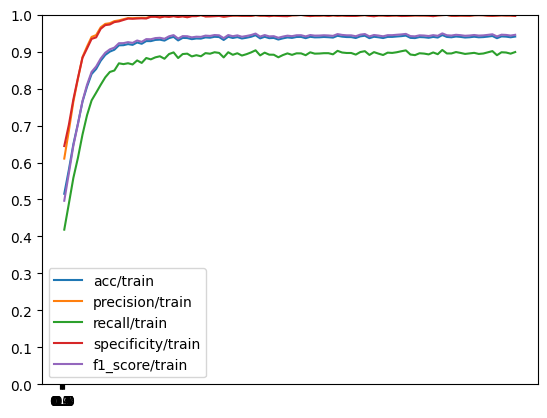

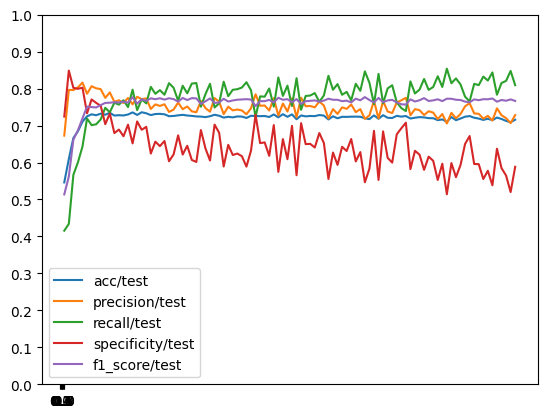

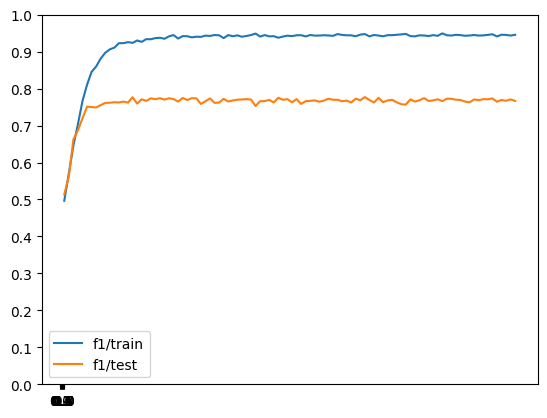

In [ ]:
## Plotting
import matplotlib.pyplot as plt

plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0.0, 1.0 + 0.1, 0.1))

for m in ("acc", "precision", "recall", "specificity", "f1_score"):
    plt.plot(list(range(1, epochs + 1)), meter.history[m], label=f"{m}/train")

plt.legend(loc="lower left")
plt.savefig(plot_path[0])
plt.show()

plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0.0, 1.0 + 0.1, 0.1))

for m in ("acc", "precision", "recall", "specificity", "f1_score"):
    plt.plot(list(range(1, epochs + 1)), test_meter.history[m], label=f"{m}/test")

plt.legend(loc="lower left")
plt.savefig(plot_path[1])
plt.show()

plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0.0, 1.0 + 0.1, 0.1))

plt.plot(list(range(1, epochs + 1)), meter.history["f1_score"], label=f"f1/train")
plt.plot(list(range(1, epochs + 1)), test_meter.history["f1_score"], label=f"f1/test")

plt.legend(loc="lower left")
plt.savefig(plot_path[2])
plt.show()


 ## Inference in test dataset


In [ ]:
test_meter = Meter()
test_writer = Writer(log_path, overwrite=False)

## Evaluation mode
model.eval()
with torch.no_grad():
    for feat, labels in tqdm(testloader, total=len(testloader)):
        feat = feat.to(device)
        labels = labels.to(device)
        out = model(feat)
        test_meter.update(out, labels)

print("Inference (test metrics)")
test_writer.file.write("Inference (test metrics)\n")
test_writer.print_info(test_meter, 0, mode="test", inference=True)
test_writer.end_writer()

100%|██████████| 150/150 [00:32<00:00,  4.61it/s]

Inference (test metrics)
--------------------------------------------------------------------------------
acc/test: 0.7157817572520683
precision/test: 0.7283123672602516
recall/test: 0.8092212742784535
spec/test: 0.5883663366336633
f1/test: 0.7666380051590714
--------------------------------------------------------------------------------


## Loading checkpoints and calculation PR and ROC

In [ ]:
## plotting precision vs recall curve
def plot_curve(metric1,
               metric2,
               metric1_name: str,
               metric2_name: str,
               model: MLP,
               resolution: int = 200,
               savepath : str = None):
    import matplotlib.pyplot as plt

    m1_list = []
    m2_list = []
    out_batches = []
    label_batches = []
    plot_meter = Meter()

    model.eval()
    with torch.no_grad():
        for feat, label in tqdm(testloader, total=len(testloader)):
            feat = feat.to(device)
            label = label.to(device)
            out = model(feat)
            out_batches.append(out)
            label_batches.append(label)

    for i in range(resolution):
        threshold = (i / resolution)
        plot_meter.reset()
        for out, labels in zip(out_batches, label_batches):
            plot_meter.update(out, labels, threshold)
        m1_list.append(metric1(plot_meter))
        m2_list.append(metric2(plot_meter))

    plot_meter.reset()
    for out, labels in zip(out_batches, label_batches):
        plot_meter.update(out, labels, 0.5)
    print(f"Acc: {plot_meter.acc()}")

    idx = np.lexsort((m1_list, m2_list))


    plt.xticks(np.arange(0.0, 1.0 + 0.1, 0.1))
    plt.yticks(np.arange(0.0, 1.0 + 0.1, 0.1))
    plt.ylim(0.0, 1.0)
    plt.plot([m1_list[i] for i in idx], [m2_list[i] for i in idx])
    plt.xlabel(metric1_name)
    plt.ylabel(metric2_name)

    if savepath is not None:
        print(f"Saving to {savepath}")
        plt.savefig(savepath)
    plt.show()

In [ ]:
# trainloader = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=shuffle,
#                           num_workers=num_workers)
# testloader = DataLoader(test_dataset,
#                         batch_size=batch_size,
#                         shuffle=shuffle,
#                         num_workers=num_workers)

In [ ]:
model = MLP(feat_dim, layers, dropouts, leak)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

100%|██████████| 150/150 [00:32<00:00,  4.55it/s]


Acc: 0.7125353440150801
Saving to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/roc_mlp_model7_2023-10-28 15:39:53.399024.pdf


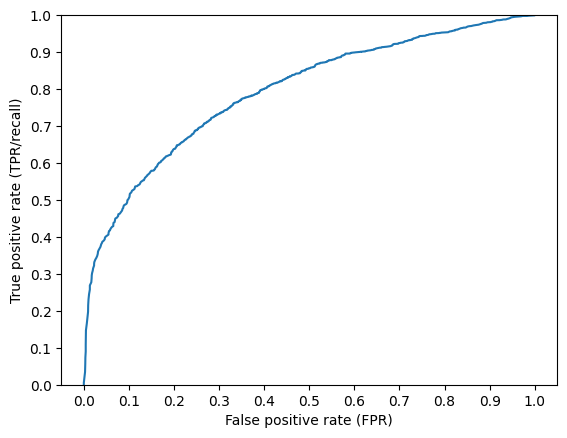

100%|██████████| 150/150 [00:33<00:00,  4.53it/s]


Acc: 0.7125353440150801
Saving to /content/drive/MyDrive/4o-SEMESTRE/IC0009/pratica4/model7/pr_path_model7_2023-10-28 15:39:53.399101.pdf


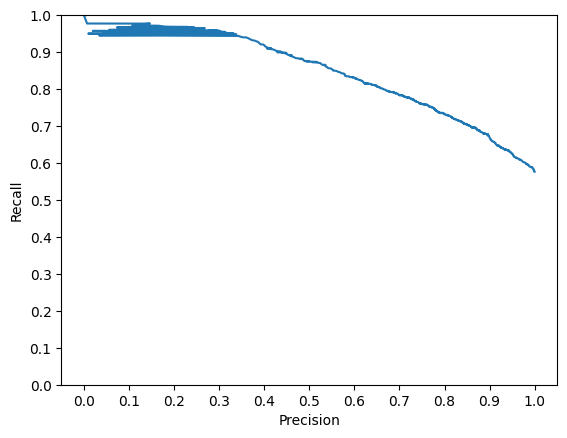

In [ ]:
fpr = lambda meter: meter.FP / (meter.FP + meter.TN)
plot_curve(fpr, Meter.recall,
           "False positive rate (FPR)",
           "True positive rate (TPR/recall)",
           model,
           roc_resolution,
           roc_path)
plot_curve(Meter.recall, Meter.precision,
           "Precision",
           "Recall",
           model,
           pr_resolution,
           pr_path)